In [1]:
import torch
from RegularizingEmbeddings.regularization import TanglingRegularization
from RegularizingEmbeddings.data.data_generation import make_trajectories, postprocess_data
import hydra
from hydra.core.global_hydra import GlobalHydra
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/om2/user/ostrow/anaconda/envs/reg_embed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize Hydra if it hasn't been already
if not GlobalHydra().is_initialized():
    hydra.initialize(config_path="conf", version_base=None)

# Now load the config
config = hydra.compose(config_name="config")


# Tangling
This notebook shows how to use `TanglingRegularization` to compute tangling at points along a trajectory. 
It expects inputs of shape `batch_size x sequence_length x embedding_dim` and returns a metric `Q` of shape `batch_size x sequence_length - 1`.

The score `Q` should be higher when there's points within a trajectory (or in other trajectories in the same batch) that are nearby but with derivatives pointing in different directions.
It works well on two toy datasets, a 2d knot and a sphere with tangles, but it seems to fail on the Lorenz system.

## Utility functions
### Data generation


In [3]:
def generate_2d_knot(n_points=500) -> torch.Tensor:
    t = np.linspace(0, 2*np.pi, n_points)
    x = np.sin(7*t)
    y = np.cos(4*t)
    values = np.stack([x, y], axis=-1)
    values = torch.tensor(values).unsqueeze(0)
    return values, np.diff(t).mean()

def generate_sphere_tangle(n_points=500, n_loops=3, batch_size=1, variation=0.3):
    """Generate a tangled trajectory on a unit sphere.
    
    Args:
        n_points: Number of points in the trajectory
        n_loops: Controls complexity of the tangle
    
    Returns:
        values: Tensor of shape (1, n_points, 3) containing the trajectory
    """
    t = np.linspace(0, 2*np.pi, n_points)
    
  # Generate batch of trajectories with variations
    all_values = []
    for b in range(batch_size):
        # Add random variations to parameters for each batch
        n_loops_b = n_loops * (1 + variation * np.random.randn())
        phase_shift = 2 * np.pi * np.random.rand()
        amplitude = 0.8 * (1 + 0.5 * variation * np.random.randn())
        
        # Generate spherical coordinates with variations
        theta = np.pi/2 + amplitude * np.sin(n_loops_b*t + phase_shift) * np.cos(2*t)
        phi = t + np.sin(3*t + phase_shift)
        
        # Convert to Cartesian coordinates
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        
        values = np.stack([x, y, z], axis=-1)
        all_values.append(values)
    
    all_values = np.stack(all_values, axis=0)
    return torch.tensor(all_values)

def generate_lorenz_trajectory( batch_size=1):

    eq, sol, dt = make_trajectories(config)
    values = postprocess_data(config, sol)

    # subset of batches
    values = values[:batch_size, :, :]
    return torch.tensor(values), dt

### Visualization

In [4]:
def visualize_Q_distribution(Q):
    plt.hist(Q.flatten().numpy(), bins=100, density=True, log=True)


def visualize_knot_2d(values, metric=None, s=5  ):
    if metric is None:
        metric = np.ones(values.shape[1])
        kwargs = {}
    else:
        kwargs = {'cmap': 'Reds', 'norm': LogNorm()}
    f, ax = plt.subplots(1, 1)
    ax.scatter(values[:, :, 0], values[:, :, 1], c=metric, **kwargs, s=s)
    ax.set_aspect('equal')
    return f, ax



def visualize_sphere_tangle(values, Q=None):
    f = plt.figure(figsize=(10, 10))
    ax = f.add_subplot(111, projection='3d')

    if Q is None:
        Q = None
        kwargs = {}
    else:
        Q = Q.numpy()
        kwargs = {'cmap': 'Reds', 'norm': LogNorm()}

    # Plot a semi-transparent unit sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, alpha=0.1, color='gray')

    # Plot the trajectory(s)
    for b in range(values.shape[0]):
        ax.scatter(values[b, :, 0], values[b, :, 1], values[b, :, 2],
                c=Q[b] if Q is not None else None, s=5,
                **kwargs,
        )
    

    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    return f

def visualize_lorenz(values, Q):
    f = plt.figure(figsize=(10, 10))
    ax = f.add_subplot(111, projection='3d')

    for b in range(values.shape[0]):
        ax.scatter(values[b, :, 0], values[b, :, 1], values[b, :, 2], 
               c=Q[b].numpy(), cmap='Reds', norm=LogNorm())
    
    # ax = plt.axes()
    # for b in range(values.shape[0]):
    #     ax.scatter(values[b, :, 0], values[b, :, 1], c=Q[b].numpy(), cmap='Reds', norm=LogNorm())

    return f



## Knot figure
A 2d planar trajectory that crosses over itself.   `B = 1`

(<Figure size 640x480 with 1 Axes>, <Axes: >)

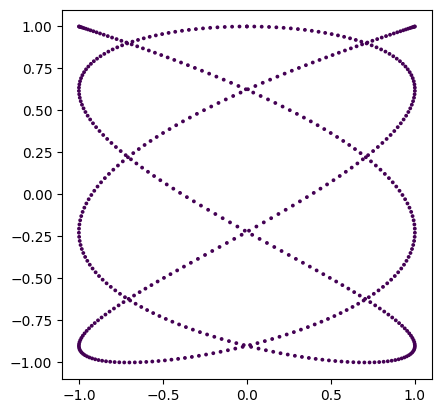

In [5]:
values, dT = generate_2d_knot()
visualize_knot_2d(values, s=3)

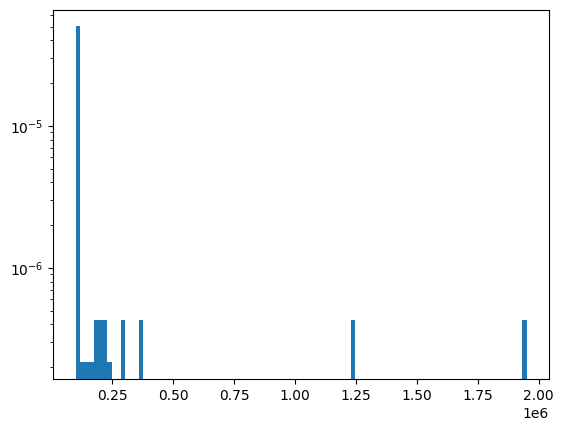

In [6]:
# fit reg
reg = TanglingRegularization(mode='efficient', dT=dT)
Q = reg(values)

visualize_Q_distribution(Q)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

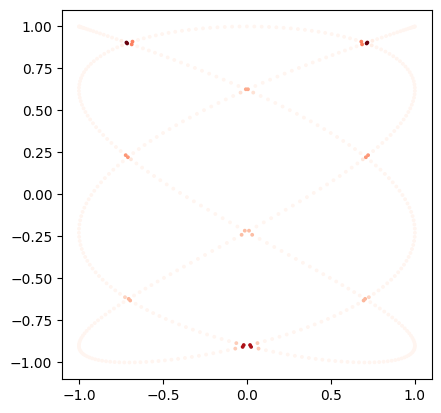

In [7]:
# visualize high tangling regions (darker shades)
visualize_knot_2d(values[:, 1:, :], metric=Q, s=3)

## 3D sphere
A set of trajectories over a unit sphere with some intersections.

torch.Size([2, 2500, 3])


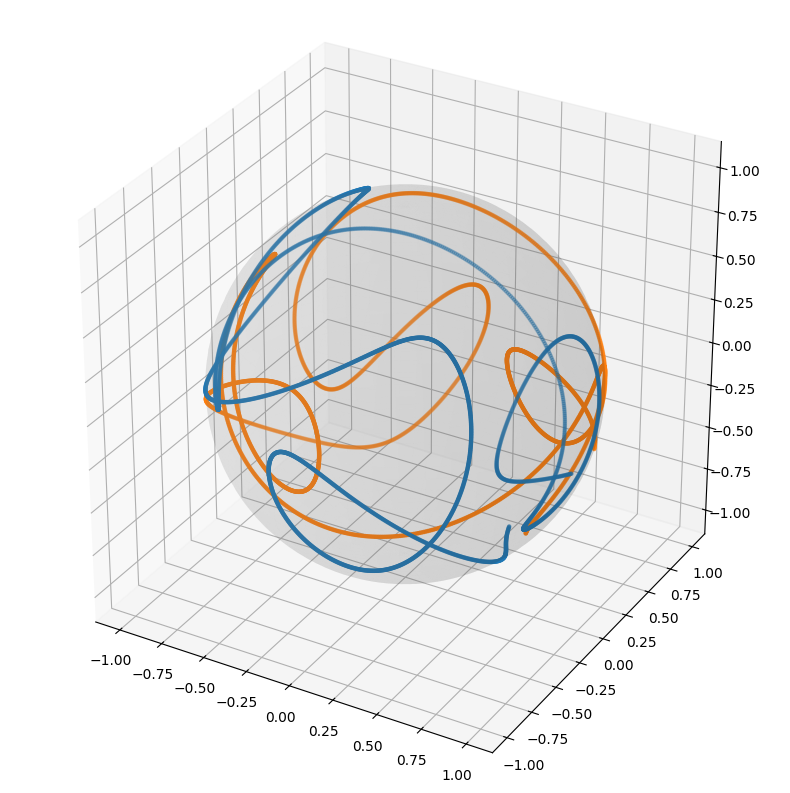

In [9]:
# Generate a batch of 2 trajectories with 5 loops each
values = generate_sphere_tangle(n_points=2500, n_loops=5, batch_size=2)
print(values.shape)

# Visualize
visualize_sphere_tangle(values);


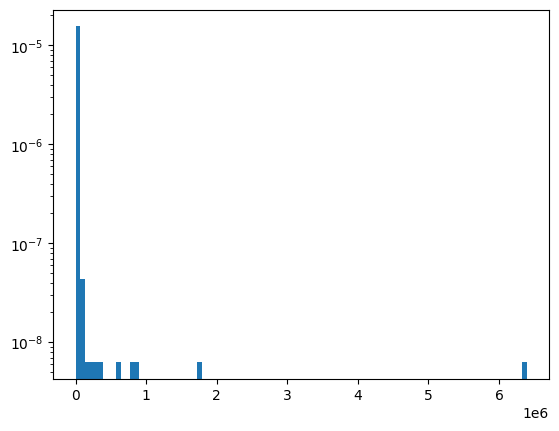

In [10]:
reg = TanglingRegularization(mode='efficient', dT=dT)
Q = reg(values)

visualize_Q_distribution(Q)

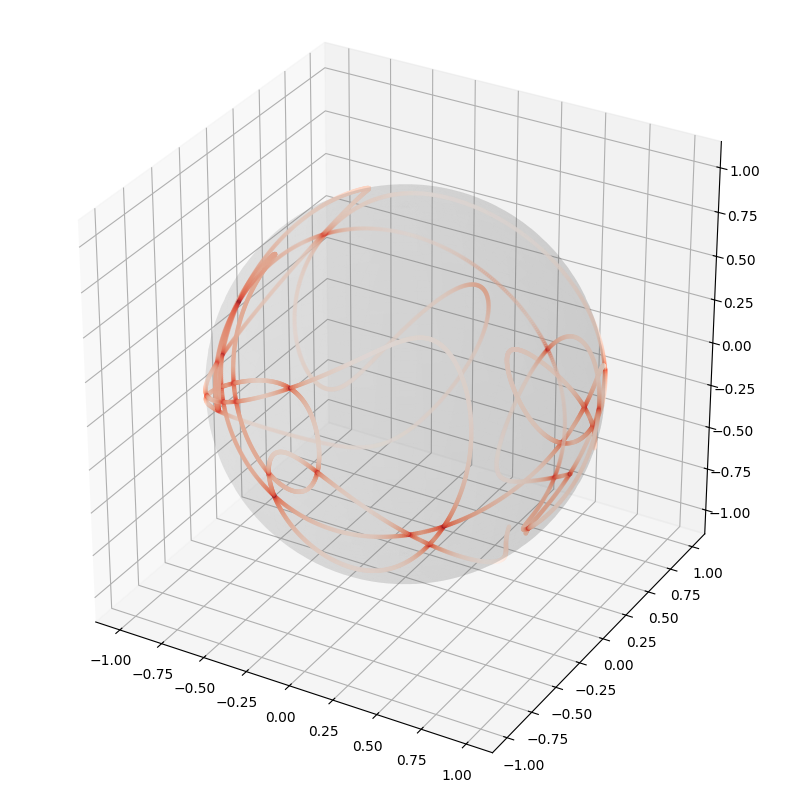

In [11]:
visualize_sphere_tangle(values[:, 1:, :], Q);

## Lorenz

It **fails** on lorenz. There's points in that should be in regions with low tangling that are very dark red, and ares in the tangled regions that are not very dark red.

In [43]:
config.data.trajectory_params.n_periods = 60

In [44]:
values, dT = generate_lorenz_trajectory(batch_size=1)
print(values.shape)

# values = values[:,::2]

torch.Size([1, 12000, 3])


torch.Size([1, 11999])


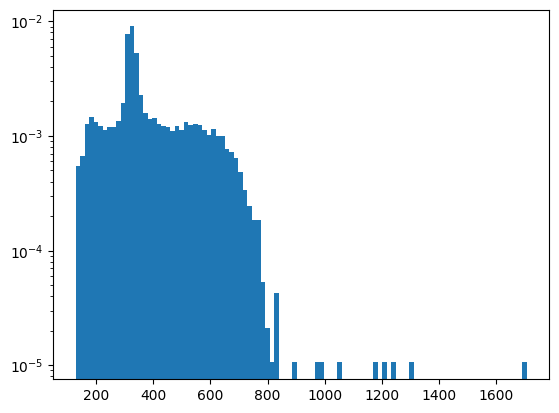

In [45]:
reg = TanglingRegularization(mode='efficient', dT=dT)
Q = reg(values)
print(Q.shape)
plt.hist(Q.flatten().numpy(), bins=100, density=True, log=True)
plt.show()



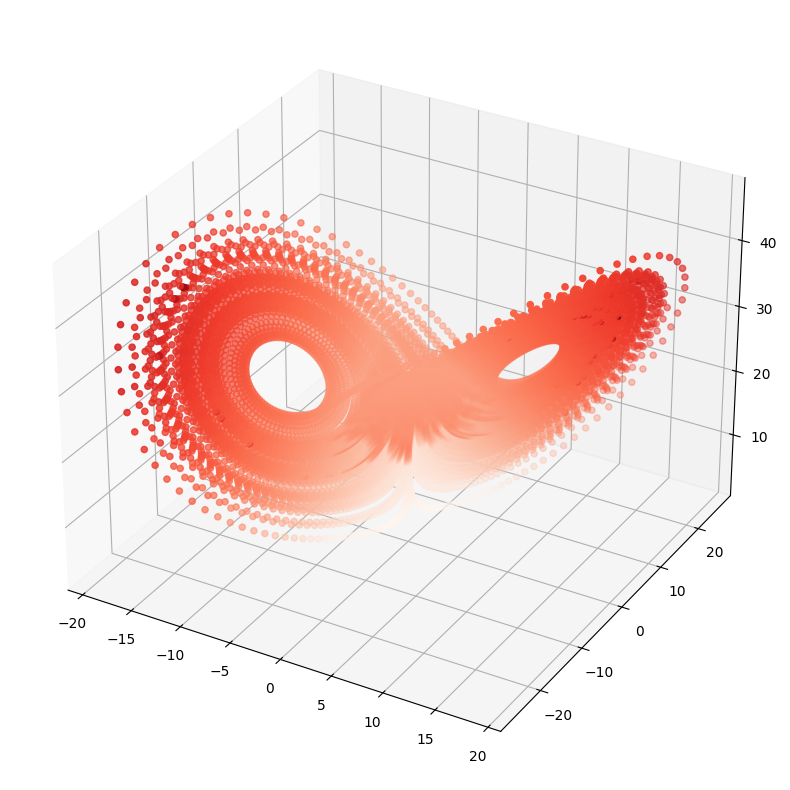

In [46]:
visualize_lorenz(values[:, 1:, :], Q[:, :]);
